In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from controller.ppo_wm import Agent
from vision.vAE import VAE
from data.car_racing import CarRacingWrapper
from memory_v2 import Memory as Memory_v2
from memory import Memory
import numpy as np
import tensorflow as tf

### Understanding **tf.element_spec**

In [2]:
dummy = tf.data.Dataset.from_tensor_slices(
    (np.zeros(999*35).reshape(999,35).astype(np.float32), np.zeros(999*32).reshape(999,32).astype(np.float32))
)
dummy.element_spec

(TensorSpec(shape=(35,), dtype=tf.float32, name=None),
 TensorSpec(shape=(32,), dtype=tf.float32, name=None))

In [3]:
t_spec = dummy.element_spec

In [4]:
ds = tf.data.experimental.load(
    os.getcwd() + '/saved_data/z_vae160',
    compression='GZIP',
    element_spec=(tf.TensorSpec(shape=(999, 35), dtype=tf.float32), tf.TensorSpec(shape=(999, 32), dtype=tf.float32))
)
ds

<_LoadDataset shapes: ((999, 35), (999, 32)), types: (tf.float32, tf.float32)>

In [5]:
ds = ds.shuffle(1).batch(4).prefetch(tf.data.experimental.AUTOTUNE)

In [6]:
len(ds)

63

In [7]:
ds = ds.map(lambda x, y: (tf.cast(x, tf.float64), tf.cast(y, tf.float64)))

In [8]:
import time

def train(model, data, epochs):
    epoch_losses = []
    for e in range(epochs):
        t = time.time()
        batch_losses = []
        data = data.shuffle(1)
        
        for (x, y) in data.take(20):
            state = model.get_zero_hidden_state(x)
            batch_losses.append(model.train_op(x, y, state))
            
        epoch_losses.append(np.mean(batch_losses))
        print(f"Epoch: {e} done - Loss: {epoch_losses[-1]} - Time: {time.time()-t}")
        
    #model.save(os.getcwd() + '/160model_v2')
        
    return batch_losses

In [9]:
mem = Memory_v2()
loss = []

In [10]:
loss.append(train(mem, ds, 1))

Epoch: 0 done - Loss: 41.64740587167008 - Time: 292.95205187797546


In [36]:
mem.save_weights(os.getcwd() + '/160model_v2')

In [37]:
mem2 = Memory_v2()
mem2.load_weights(os.getcwd() + '/160model_v2')

In [21]:
memory_og = Memory(num_timesteps=1, batch_size=1,load_model=True, results_dir=os.getcwd() + '/160model')

loading model from /Users/floyd/Documents/Studium/Coxi6/DRL/World-Model-CarRacing-with-PPO/world_model/memory/160model/models


## Visualizing performance

In [13]:
import matplotlib.pyplot as plt

In [14]:
vision = VAE(results_dir=os.getcwd()[:-6] + 'vision', load_model=True)

loading model from /Users/floyd/Documents/Studium/Coxi6/DRL/World-Model-CarRacing-with-PPO/world_model/vision/models


In [42]:
def dream(memory, n=2):
    fig, ax = plt.subplots(ncols=2, nrows=n)

    for i, (x, y) in enumerate(ds.take(n)):
        
        x = x.numpy()
        #x = tf.cast(x[0,0,:], tf.float64)
        
        state = memory.get_zero_hidden_state(x)
        mix_params, _, _ = memory(x, state, temperature=1.0)
        pred = memory.get_y_pred(mix_params)
        
        ax[i, 0].imshow(tf.squeeze(vision.decoder(pred[0,0])))
        ax[i, 0].set_title("Dream")
        ax[i, 0].axis("off")
        
        ax[i, 1].imshow(tf.squeeze(vision.decoder(y.numpy()[0,0].reshape(1,32))))
        ax[i, 1].set_title("Truth")
        ax[i, 1].axis("off")

    plt.show()

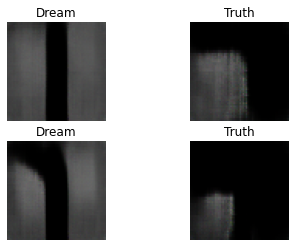

In [44]:
dream(mem, n=2)

# An attempt to train on memory_v2

In [50]:
from collections import defaultdict
def train_controller(controller, vision, memory, collect_data=False, episode_length=1000, render=False):
    """ runs a single episode """
    #  needs to be imported here for multiprocessing

    state = memory.get_zero_hidden_state(
        np.zeros(35).reshape(1, 1, 35)
    )

    total_reward = 0
    data = defaultdict(list)
    obs = controller.env.reset()

    for step in range(episode_length):
        if render:
            controller.env.render("human")
        obs = obs.reshape(1, 64, 64, 1).astype(np.float32)
        # Collecting mu and logvar for data collection
        mu, logvar = vision.encode(obs)
        z = vision.reparameterize(mu, logvar)
        # encoded obs plus hidden state from memory --> controller input
        z_state = np.concatenate([z, state], axis=None)
        print(z_state.shape)
        #action = controller.actor.get_action(z_state)
        action = controller.env.action_space.sample()
        obs, reward, done, _ = env.step(action)

        action = tf.cast(action, tf.float64)
        x = tf.concat([
            tf.reshape(z, (1, 1, 32)),
            tf.reshape(action, (1, 1, 3))
        ], axis=2)
        # state :: hidden_state (,256) & cell_state (,256)
        # Shouldnt it be hidden_state and prediction of new state space z? (Mixture-ouput y)?
        # NOOO we dont use the pred_z (y) for training the controller
        y, h_state, c_state = memory(x, tf.cast(state, tf.float64), temperature=1.0)

        # Why is c_state part of the state that gets feed into the controller?
        #  Only plausible if c_state == latent space of
        state = [h_state, c_state]
        total_reward += reward

        if done:
            print('done at {} - reward {}'.format(step, reward))
            break

        if collect_data:
            reconstruct = vision.decoder(z)
            vae_loss = vision.loss(reconstruct)
            data['observation'].append(obs)
            data['latent'].append(np.squeeze(z))
            data['reconstruct'].append(np.squeeze(reconstruct))
            data['reconstruction-loss'].append(vae_loss['reconstruction-loss']),
            data['unclipped-kl-loss'].append(vae_loss['unclipped-kl-loss'])
            data['action'].append(action)
            data['mu'].append(mu)
            data['logvar'].append(logvar)
            data['pred-latent'].append(y)
            data['pred-reconstruct'].append(np.squeeze(vision.decode(y.reshape(1, 32))))
            data['total-reward'].append(total_reward)

    env.close()
    return total_reward, data


In [48]:
env = CarRacingWrapper()
controller = Agent(env)
vision = VAE(load_model=True, results_dir=os.getcwd()[:-6] + 'vision')
mem2 = Memory_v2()
mem2.load_weights(os.getcwd() + '/160model_v2')

loading model from /Users/floyd/Documents/Studium/Coxi6/DRL/World-Model-CarRacing-with-PPO/world_model/vision/models


In [49]:
r, d = train_controller(controller, vision, mem2, collect_data=False)
print(r)

Track generation: 1116..1399 -> 283-tiles track
(544,)


InvalidArgumentError: Input to reshape is a tensor with 35 values, but the requested shape has 34965 [Op:Reshape]